<p style="font-size:16px;">
This notebook processes Muse EEG CSV data, derives <b>average band powers</b>, computes an <b>Engagement Index (EI)</b>, smooths EI with a <b>rolling median</b>, and exports a <b>slim dataset</b> for plotting and analysis. All analysis is surface level and preliminary. For more detail, refer to the full documentation attached on git. 

**- Eric Miao**
</p>


## Phase 1: EEG Preprocessing and Engagement Index Construction

In Phase 1, raw Muse EEG data is cleaned, filtered, and transformed into an analysis-ready engagement signal.

This includes:
- Removing unnecessary sensor columns
- Handling signal dropouts and invalid values
- Applying a Butterworth filter to reduce noise and isolate relevant frequency components
- Averaging band power across electrodes
- Converting log-scale power to linear scale
- Computing the Engagement Index (EI = Beta / (Alpha + Theta))
- Applying a ~20-second rolling median to stabilize short-term fluctuations
- Exporting a slim dataset for downstream analysis

The outcome of Phase 1 is a filtered and smoothed engagement time series suitable for fatigue detection, threshold modeling, and statistical analysis.



**Cell 1 — Import Dependencies**

This cell loads all required Python libraries for data processing, visualization, and modeling.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import glob
import os
from scipy.signal import butter, filtfilt
import re


**Cell 2 - Load Raw CSV Data from EEG**

In [2]:
folder_path = "/Users/ericmiao/Desktop/EEGProject2.19"

# Find all CSV files matching the pattern: 2 letters followed by a number (e.g., EM3, FB5)
pattern = re.compile(r'^[A-Za-z]{2}\d+\.csv$')
csv_files = [f for f in os.listdir(folder_path) if pattern.match(f)]

# Make sure there is exactly one matching CSV
if len(csv_files) == 1:
    file_path = os.path.join(folder_path, csv_files[0])
    df = pd.read_csv(file_path)
    print("Loaded:", csv_files[0])
else:
    raise ValueError(f"Expected exactly one CSV matching '[2 letters][number].csv', found {len(csv_files)}: {csv_files}")

Loaded: SD9.csv


**Cell 3 - Dropping unessecary columns**

In this preprocessing step, acceleration data, gyroscope data, battery level, and raw EEG signals are removed, as the analysis will rely exclusively on processed EEG band power features.

You may notice some NAN values at this point. These may have occured from poor physcial connection of the Muse headband. Regardless, this is not a problem, we will interpolate in a future step.

In [3]:
columns_to_drop = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 
                   'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 
                   'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'PPG_Ambient', 'PPG_IR', 'PPG_Red',
                   'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Heart_Rate,Elements
0,2026-02-15 16:26:54.760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected Muse-FDD4
1,2026-02-15 16:26:55.360,0.954075,0.847746,0.286351,1.333906,0.881592,0.000000,0.000000,0.640962,0.621068,...,1.908621,1.273442,1.831922,1.341616,0.913670,1.197230,0.456530,0.951582,64.895434,NaN
2,2026-02-15 16:26:56.360,0.856817,0.875972,0.773583,0.297808,0.223641,0.268665,0.416960,1.255640,0.940210,...,1.843728,1.349179,1.379919,1.789862,0.792664,1.359658,1.171468,1.226872,63.904971,NaN
3,2026-02-15 16:26:57.360,1.100385,0.092891,0.466556,0.445697,0.882772,0.000000,0.166861,1.183920,0.728768,...,1.928515,1.155099,1.262578,1.304052,1.236752,0.967997,1.513777,0.803716,59.040242,NaN
4,2026-02-15 16:26:58.360,0.471728,0.288188,0.149651,0.814376,0.805669,0.338209,0.000000,0.741683,0.722950,...,1.796211,1.654266,1.287984,1.655802,1.527288,0.719311,1.151408,1.549155,71.037100,NaN


**Cell 4 - Converting Time** 

We need to convert the 'TimeStamp' column from date time to seconds using the to.datetime function

In [4]:
# Convert once
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], errors="coerce")

# Check conversion
print("Converted dtype:", df["TimeStamp"].dtype)
print("Number of NaT values:", df["TimeStamp"].isna().sum())

# Drop rows where TimeStamp failed to convert
df = df.dropna(subset=["TimeStamp"]).reset_index(drop=True)

# Set reference time safely
t0 = df.loc[0, "TimeStamp"]

# Create seconds column
df.insert(1, "TimeStamp_seconds",
          (df["TimeStamp"] - t0).dt.total_seconds())

print("First 5 values:", df[["TimeStamp", "TimeStamp_seconds"]].head())

Converted dtype: datetime64[ns]
Number of NaT values: 0
First 5 values:                 TimeStamp  TimeStamp_seconds
0 2026-02-15 16:26:54.760                0.0
1 2026-02-15 16:26:55.360                0.6
2 2026-02-15 16:26:56.360                1.6
3 2026-02-15 16:26:57.360                2.6
4 2026-02-15 16:26:58.360                3.6


**Cell 5 - Interpolation**

As mentioned in cell 3, some values are NAN (null). We need to interpolate between two known values to rectify this. This is a simple linear interpolation function

In [5]:
cols_to_interpolate = df.select_dtypes(include=[np.number]).columns
df[cols_to_interpolate] = df[cols_to_interpolate].interpolate(method="linear", limit_direction="both")

df.head()


,TimeStamp,TimeStamp_seconds,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,...,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Heart_Rate,Elements
0,2026-02-15 16:26:54.760,0.0,0.954075,0.847746,0.286351,1.333906,0.881592,0.000000,0.000000,0.640962,...,1.908621,1.273442,1.831922,1.341616,0.913670,1.197230,0.456530,0.951582,64.895434,/muse/event/connected Muse-FDD4
1,2026-02-15 16:26:55.360,0.6,0.954075,0.847746,0.286351,1.333906,0.881592,0.000000,0.000000,0.640962,...,1.908621,1.273442,1.831922,1.341616,0.913670,1.197230,0.456530,0.951582,64.895434,NaN
2,2026-02-15 16:26:56.360,1.6,0.856817,0.875972,0.773583,0.297808,0.223641,0.268665,0.416960,1.255640,...,1.843728,1.349179,1.379919,1.789862,0.792664,1.359658,1.171468,1.226872,63.904971,NaN
3,2026-02-15 16:26:57.360,2.6,1.100385,0.092891,0.466556,0.445697,0.882772,0.000000,0.166861,1.183920,...,1.928515,1.155099,1.262578,1.304052,1.236752,0.967997,1.513777,0.803716,59.040242,NaN
4,2026-02-15 16:26:58.360,3.6,0.471728,0.288188,0.149651,0.814376,0.805669,0.338209,0.000000,0.741683,...,1.796211,1.654266,1.287984,1.655802,1.527288,0.719311,1.151408,1.549155,71.037100,NaN


**Cell 6 - Nullifying Stalled Data**

In some cases, the data may stall due to poor connection to skin. To address this, we choose to nullify the portions of stalled data by setting it to NaN.

In [6]:
# ============================================================
# USER-ADJUSTABLE
STALL_WINDOW_SECONDS = 60  # data unchanged for this many seconds → treat as stalled
# ============================================================

bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
electrodes = ['TP9', 'AF7', 'AF8', 'TP10']
band_cols = [f"{b}_{e}" for b in bands for e in electrodes]

time_s = df["TimeStamp_seconds"].to_numpy(dtype=float)

total_nulled = 0
total_eeg_values = 0

for col in band_cols:
    vals = df[col].to_numpy(dtype=float)
    non_nan_count = int(np.count_nonzero(~np.isnan(vals)))
    total_eeg_values += non_nan_count
    mask = np.zeros(len(vals), dtype=bool)
    run_start = 0

    for i in range(1, len(vals)):
        # reset run on NaN or value change
        if np.isnan(vals[i]) or np.isnan(vals[run_start]) or vals[i] != vals[run_start]:
            run_start = i
            continue

        # same value — check duration
        if time_s[i] - time_s[run_start] >= STALL_WINDOW_SECONDS:
            mask[run_start : i + 1] = True

    if mask.any():
        df.loc[mask, col] = np.nan
        total_nulled += int(mask.sum())

proportion = total_nulled / total_eeg_values * 100 if total_eeg_values > 0 else 0

print(f"Stall nullification: window={STALL_WINDOW_SECONDS}s, "
      f"columns_checked={len(band_cols)}, "
      f"values_nulled={total_nulled}/{total_eeg_values} ({proportion:.2f}%)")

Stall nullification: window=60s, columns_checked=20, values_nulled=0/42200 (0.00%)


**Cell 7 - Convert Log-Scaled Band Power to Linear Power**

In this step, we convert the averaged EEG band power values from **log10 scale** back to **linear scale**.

Many consumer EEG devices export band power on a logarithmic scale because EEG power spans multiple orders of magnitude. Log scaling compresses this range, improving visualization and stability.

However, ratio-based metrics (like the Engagement Index) must be computed in **linear power**, because:

$$
\frac{\log(A)}{\log(B)} \neq \frac{A}{B}
$$

So we convert using:

$$
\text{Power}_{linear} = 10^{\text{Power}_{log10}}
$$



*In simple terms, we are just assigning the new linear power as the 10 to the power of the non-linear power*




In [7]:
# --- Convert log10-scaled band power to linear power for all 20 band-electrode columns ---

bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
electrodes = ['TP9', 'AF7', 'AF8', 'TP10']

for band in bands:
    for electrode in electrodes:
        col = f"{band}_{electrode}"
        df[f"{col}_lin"] = 10 ** df[col]

df[[c for c in df.columns if c.endswith('_lin')]].head()

,Delta_TP9_lin,Delta_AF7_lin,Delta_AF8_lin,Delta_TP10_lin,Theta_TP9_lin,Theta_AF7_lin,Theta_AF8_lin,Theta_TP10_lin,Alpha_TP9_lin,Alpha_AF7_lin,Alpha_AF8_lin,Alpha_TP10_lin,Beta_TP9_lin,Beta_AF7_lin,Beta_AF8_lin,Beta_TP10_lin,Gamma_TP9_lin,Gamma_AF7_lin,Gamma_AF8_lin,Gamma_TP10_lin
0,8.996525,7.042804,1.933531,21.572774,7.613637,1.000000,1.000000,4.374842,4.178953,5.714470,2.064132,11.306874,81.025380,18.769025,67.908208,21.959158,8.197281,15.748159,2.861081,8.945044
1,8.996525,7.042804,1.933531,21.572774,7.613637,1.000000,1.000000,4.374842,4.178953,5.714470,2.064132,11.306874,81.025380,18.769025,67.908208,21.959158,8.197281,15.748159,2.861081,8.945044
2,7.191465,7.515746,5.937212,1.985217,1.673558,1.856373,2.611919,18.015254,8.713854,6.063389,1.908716,7.192230,69.779453,22.344907,23.983870,61.639950,6.203896,22.890626,14.841178,16.860571
3,12.600428,1.238487,2.927895,2.790597,7.634349,1.000000,1.468455,15.272864,5.355109,1.977159,2.542948,8.100318,84.823287,14.292209,18.305368,20.139648,17.248542,9.289590,32.642029,6.363794
4,2.962975,1.941728,1.411404,6.521933,6.392471,2.178760,1.000000,5.516741,5.283841,5.841363,12.253611,10.799091,62.547616,45.109274,19.408161,45.269121,33.673513,5.239755,14.171236,35.412331


**Cell 8 - Filter EEG Data using a Butterworth filter**

EEG signals naturally fluctuate because the brain is constantly active and dynamic, even during steady tasks, and small movements, eye blinks, muscle activity, or changes in electrode contact can introduce additional rapid noise. We apply a Butterworth low-pass filter to remove these high-frequency fluctuations so that slow, meaningful trends in cognitive fatigue can be observed more clearly.

In [8]:
# --- Estimate sampling frequency ---
fs = 1.0 / df['TimeStamp_seconds'].diff().median()
print(f"Estimated sampling frequency: {fs:.2f} Hz")

# --- Butterworth low-pass filter parameters ---
ORDER = 4
CUTOFF_HZ = 0.01

# Design filter
b, a = butter(ORDER, CUTOFF_HZ, btype='low', fs=fs)

# --- Apply filter to each _lin column ---
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
electrodes = ['TP9', 'AF7', 'AF8', 'TP10']

for band in bands:
    for electrode in electrodes:
        col_lin = f"{band}_{electrode}_lin"
        col_filt = f"{col_lin}_filt"

        x = df[col_lin].to_numpy(dtype=float)

        # Remember which positions are NaN
        nan_mask = np.isnan(x)

        # Temporarily interpolate to fill NaNs so filtfilt can run
        x_filled = pd.Series(x).interpolate(method="linear", limit_direction="both").to_numpy()

        # Apply Butterworth filter on the gap-filled signal
        y = filtfilt(b, a, x_filled)

        # Restore NaNs at the positions that were originally NaN
        y[nan_mask] = np.nan

        df[col_filt] = y

# --- Verify new columns ---
filt_cols = [c for c in df.columns if c.endswith('_lin_filt')]
print(f"Created {len(filt_cols)} filtered columns:")
print(filt_cols)
df[filt_cols].head()

Estimated sampling frequency: 1.00 Hz
Created 20 filtered columns:
['Delta_TP9_lin_filt', 'Delta_AF7_lin_filt', 'Delta_AF8_lin_filt', 'Delta_TP10_lin_filt', 'Theta_TP9_lin_filt', 'Theta_AF7_lin_filt', 'Theta_AF8_lin_filt', 'Theta_TP10_lin_filt', 'Alpha_TP9_lin_filt', 'Alpha_AF7_lin_filt', 'Alpha_AF8_lin_filt', 'Alpha_TP10_lin_filt', 'Beta_TP9_lin_filt', 'Beta_AF7_lin_filt', 'Beta_AF8_lin_filt', 'Beta_TP10_lin_filt', 'Gamma_TP9_lin_filt', 'Gamma_AF7_lin_filt', 'Gamma_AF8_lin_filt', 'Gamma_TP10_lin_filt']


,Delta_TP9_lin_filt,Delta_AF7_lin_filt,Delta_AF8_lin_filt,Delta_TP10_lin_filt,Theta_TP9_lin_filt,Theta_AF7_lin_filt,Theta_AF8_lin_filt,Theta_TP10_lin_filt,Alpha_TP9_lin_filt,Alpha_AF7_lin_filt,Alpha_AF8_lin_filt,Alpha_TP10_lin_filt,Beta_TP9_lin_filt,Beta_AF7_lin_filt,Beta_AF8_lin_filt,Beta_TP10_lin_filt,Gamma_TP9_lin_filt,Gamma_AF7_lin_filt,Gamma_AF8_lin_filt,Gamma_TP10_lin_filt
0,9.401344,7.210350,1.835424,22.244193,8.333453,0.882844,1.245481,4.607730,5.210934,5.484827,2.226740,11.226029,88.490328,9.886430,72.042577,24.875288,-0.765095,15.905434,5.303461,9.585995
1,9.235607,6.989785,1.853317,21.530862,8.249737,0.945422,1.292275,4.682837,5.370216,5.420029,2.266834,11.097285,86.301988,11.023010,70.371728,25.448465,0.600635,15.861052,5.680972,9.971540
2,9.071692,6.770280,1.870934,20.820448,8.168217,1.007937,1.339558,4.758585,5.530420,5.354721,2.307736,10.968598,84.126642,12.141252,68.702986,26.028951,1.939800,15.817588,6.065723,10.366756
3,8.909871,6.552194,1.888251,20.114100,8.089026,1.070288,1.387250,4.834877,5.691246,5.289017,2.349365,10.840218,81.967356,13.239638,67.038947,26.615280,3.250367,15.775150,6.456922,10.771214
4,8.750410,6.335878,1.905241,19.412950,8.012292,1.132378,1.435267,4.911616,5.852389,5.223030,2.391636,10.712395,79.827131,14.316711,65.382179,27.205966,4.530399,15.733843,6.853757,11.184460


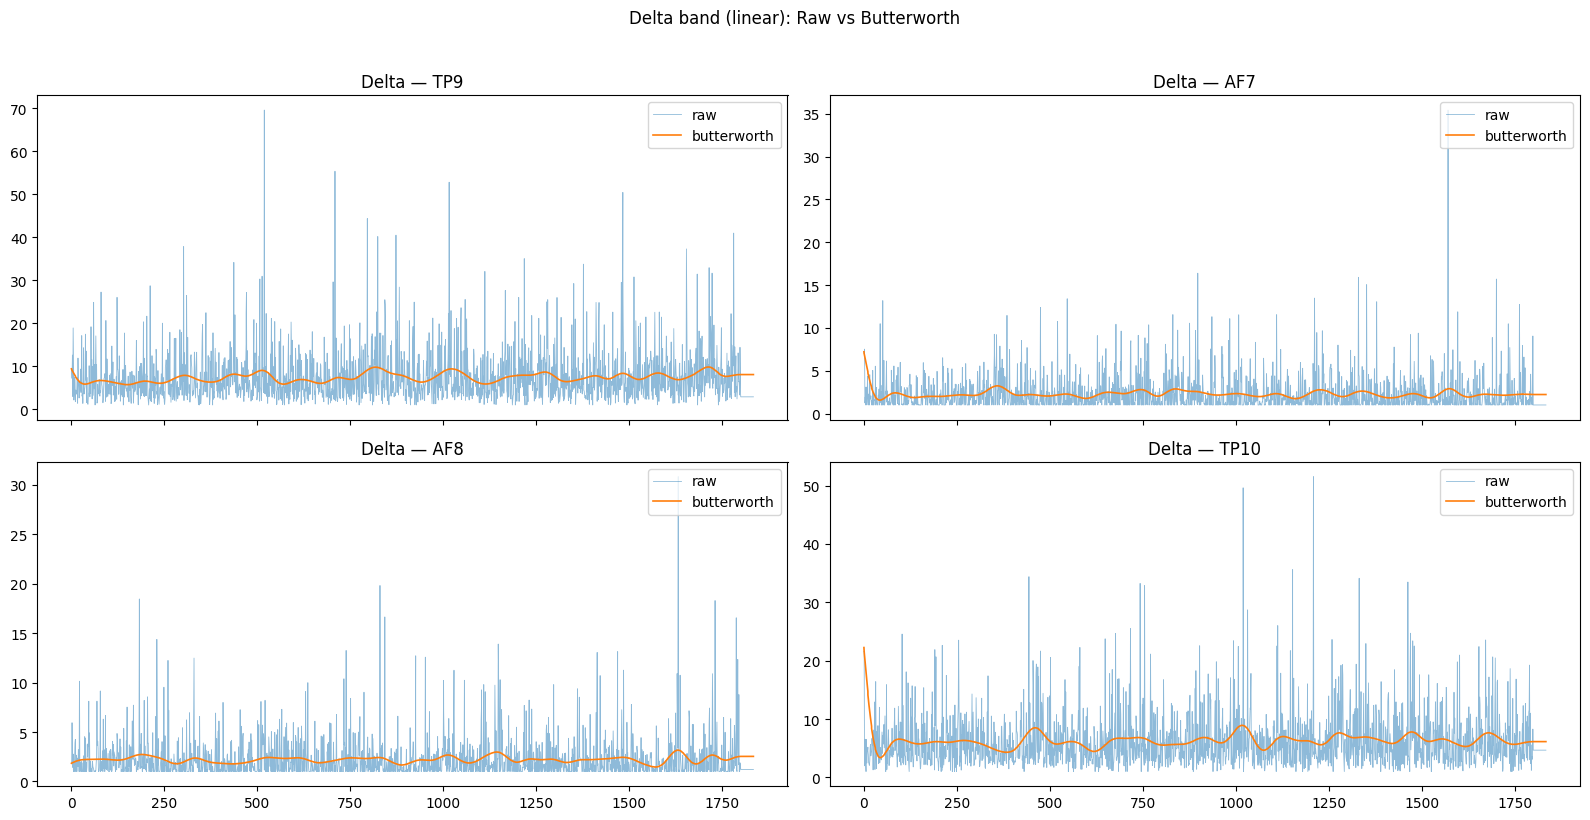

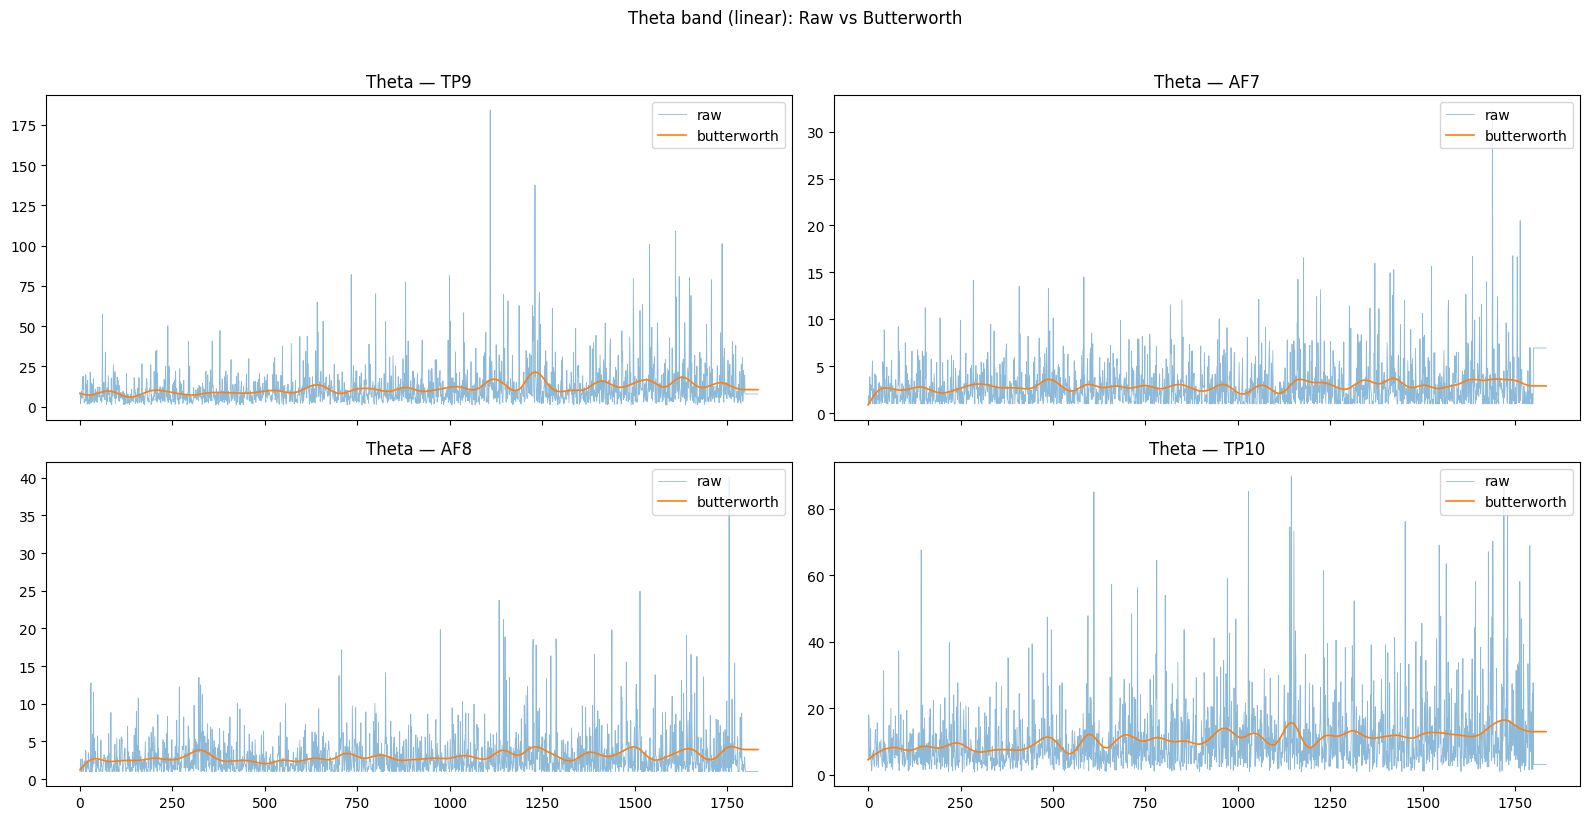

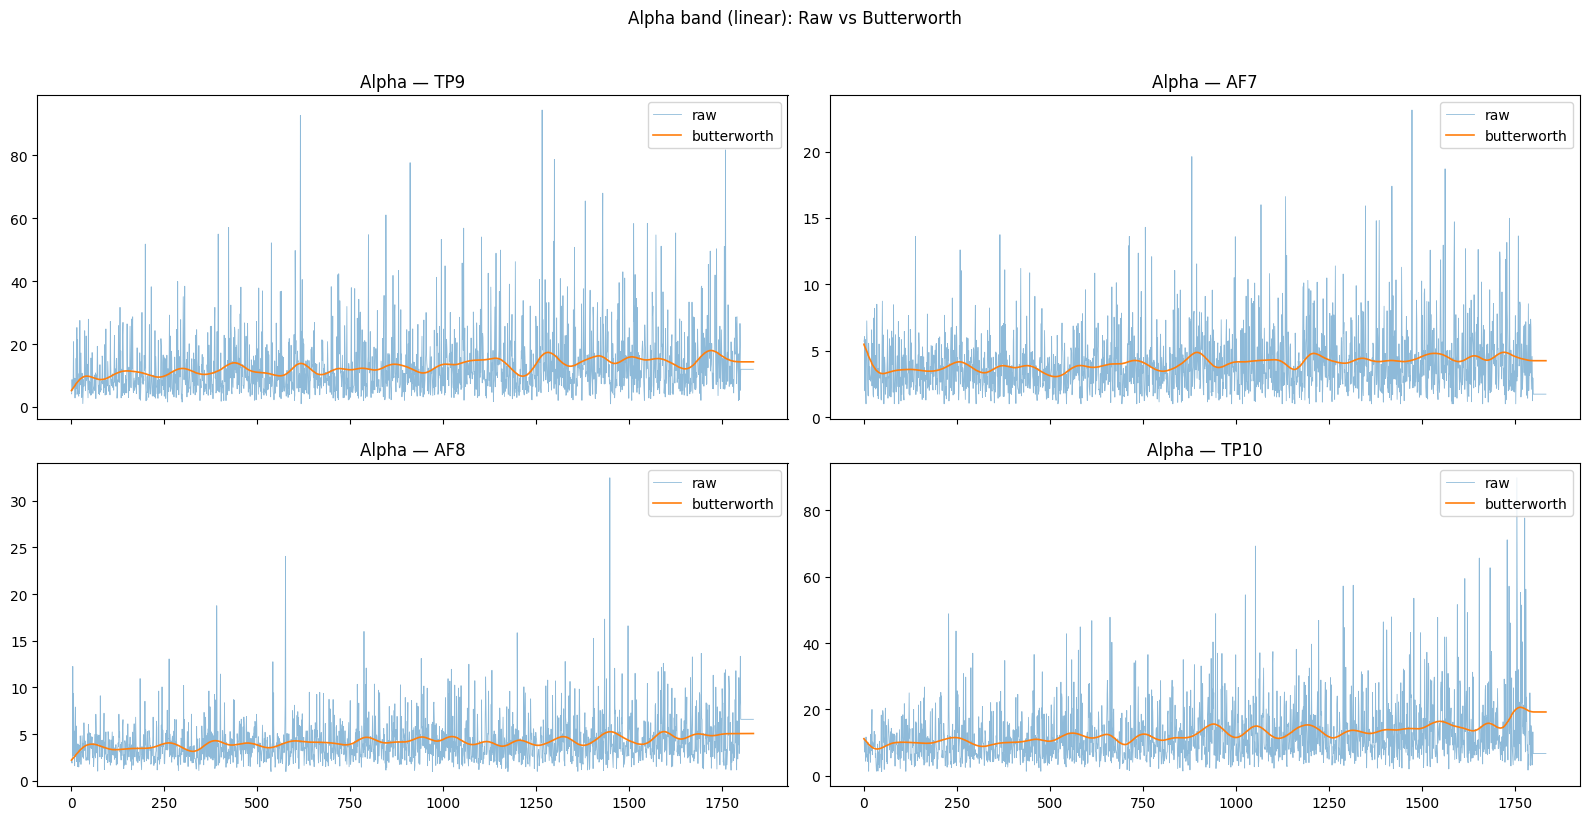

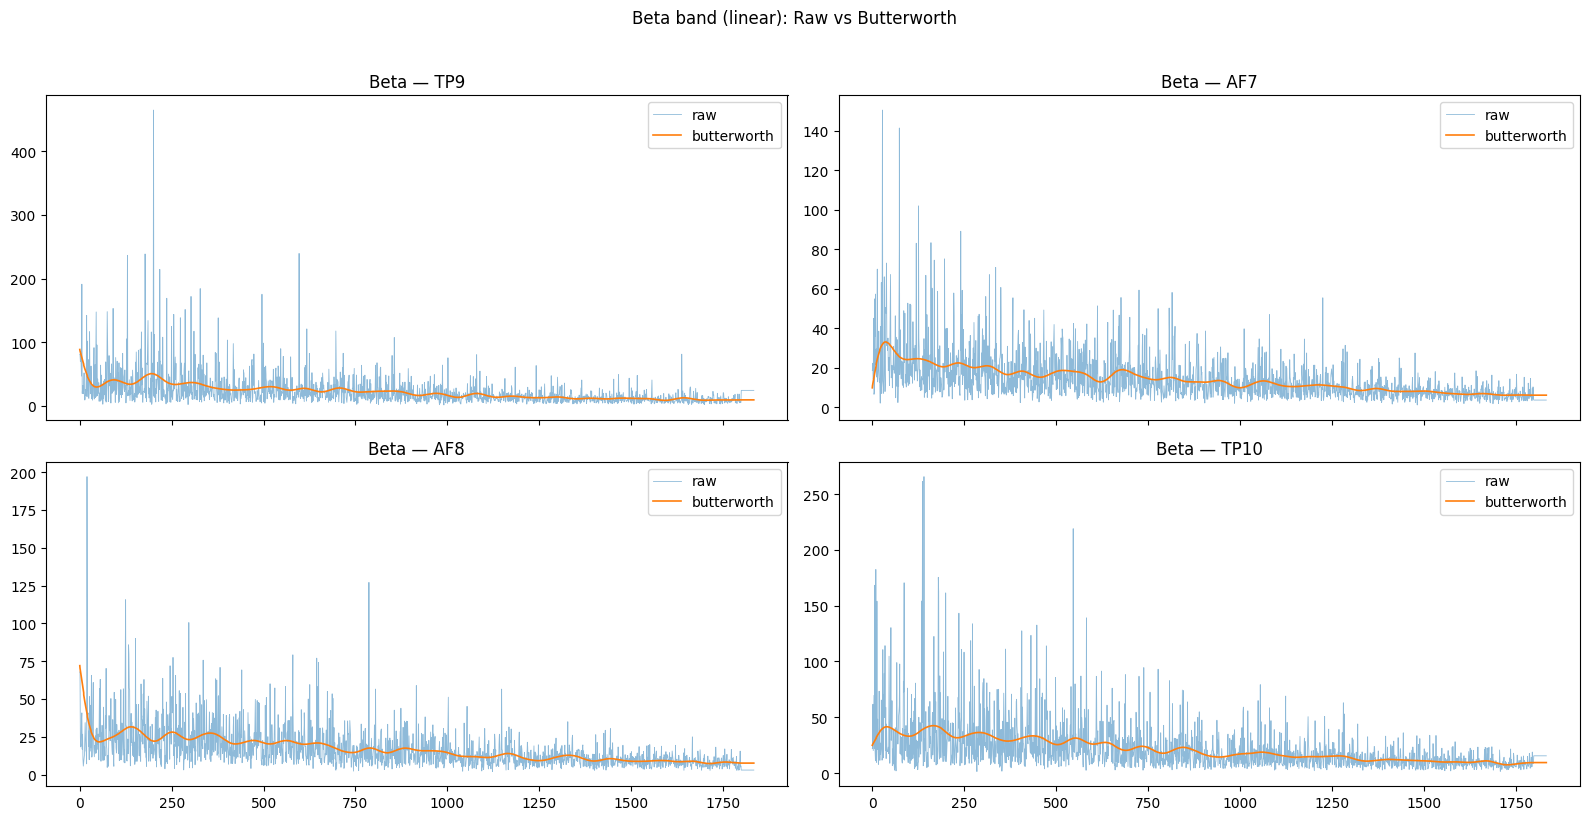

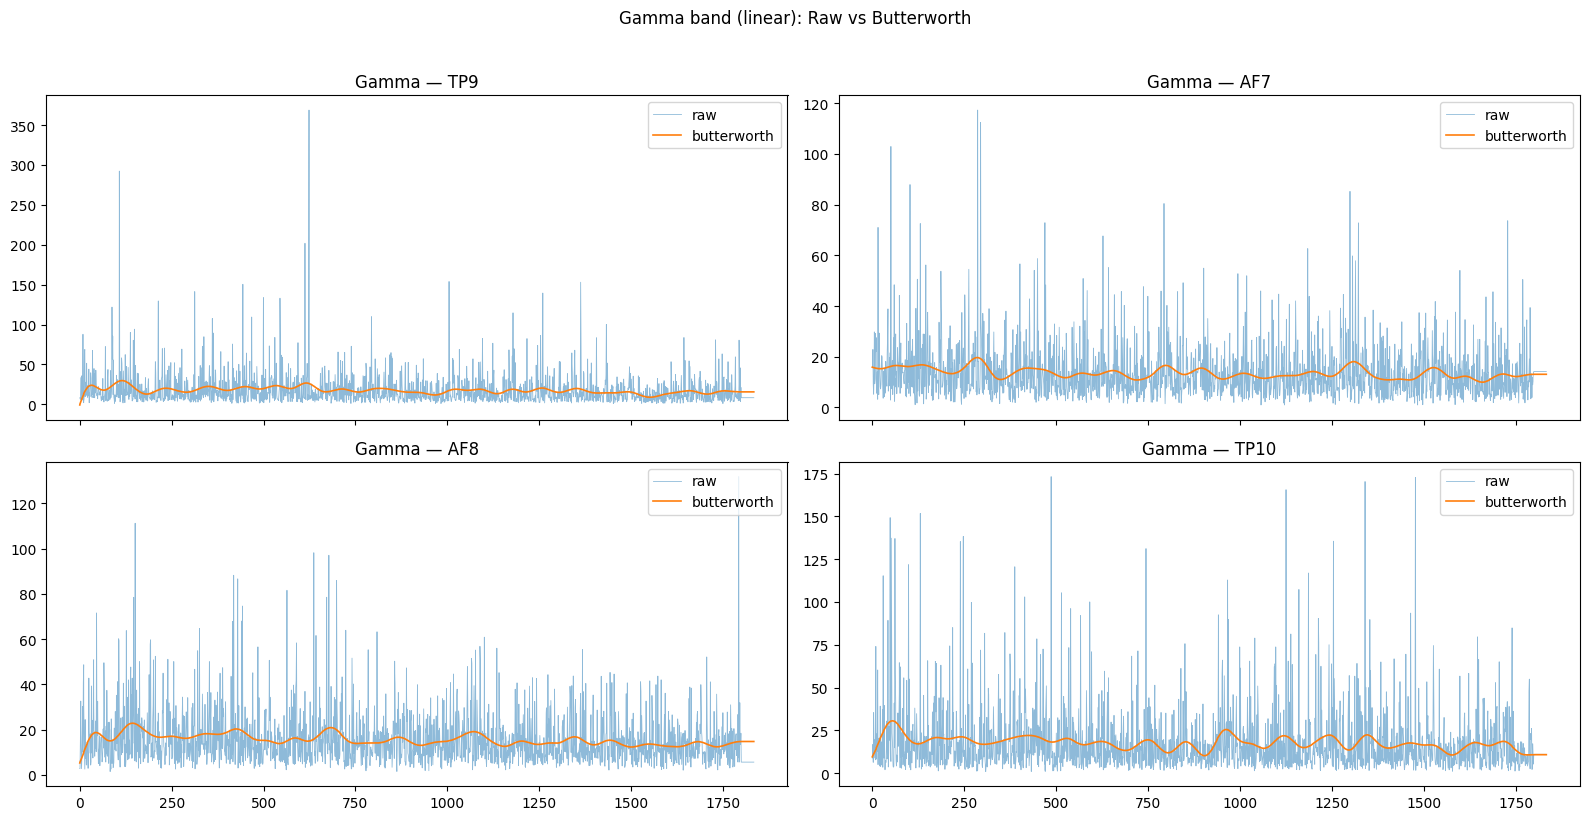

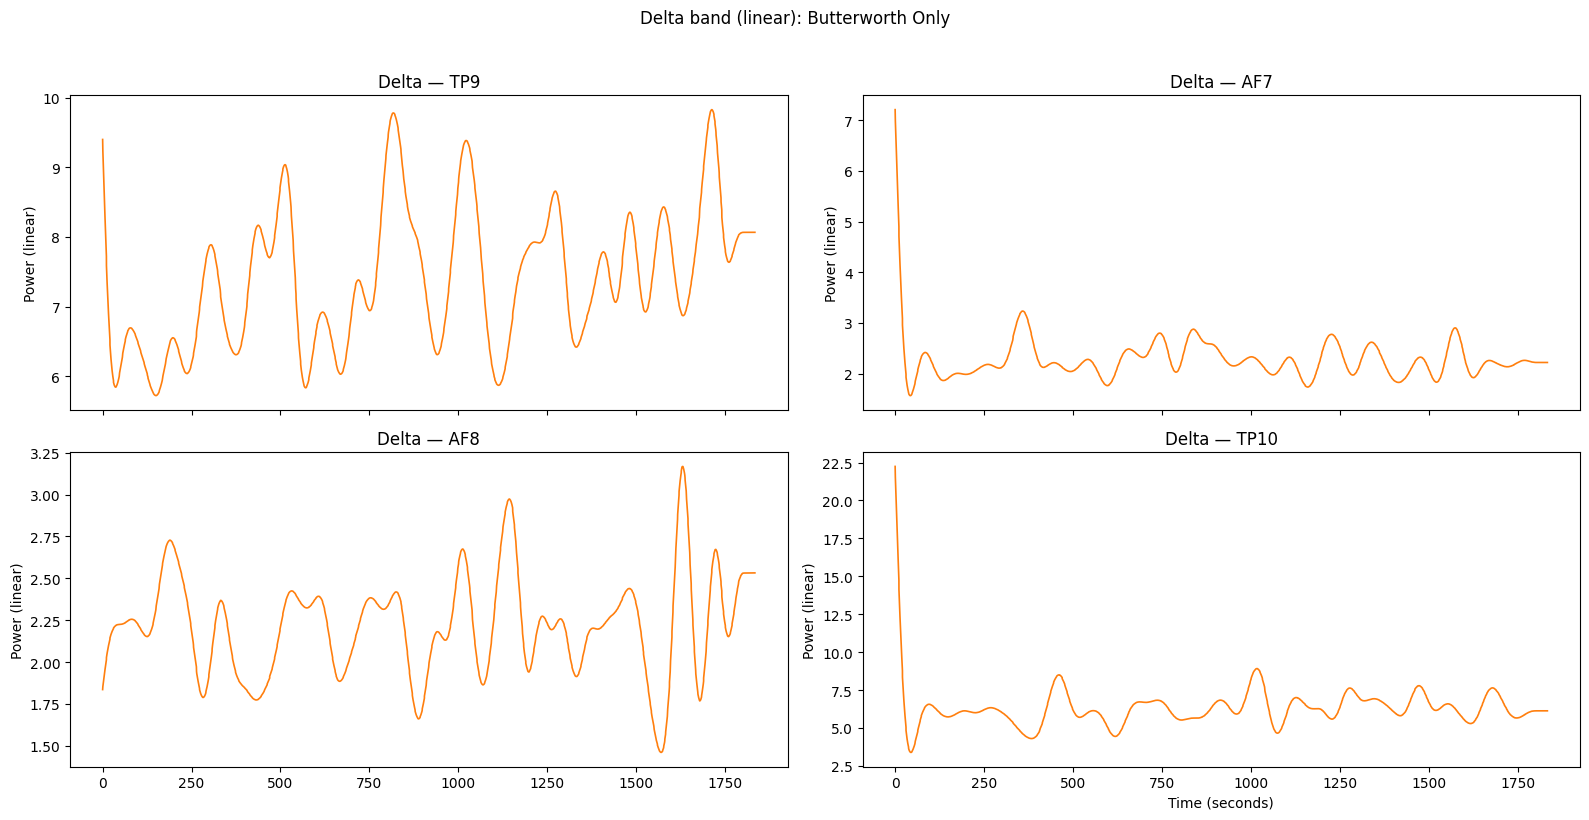

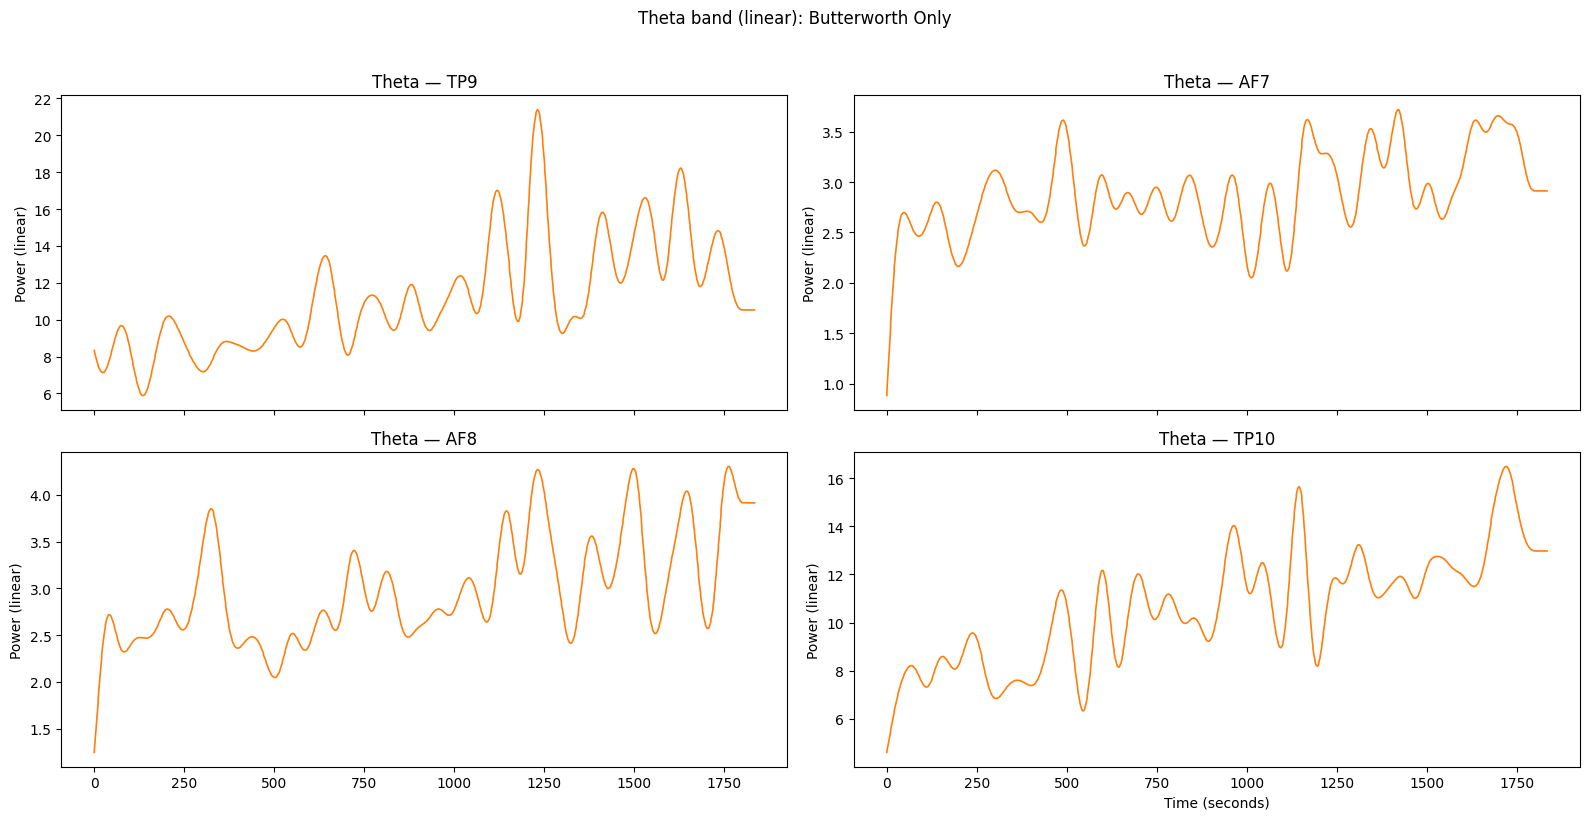

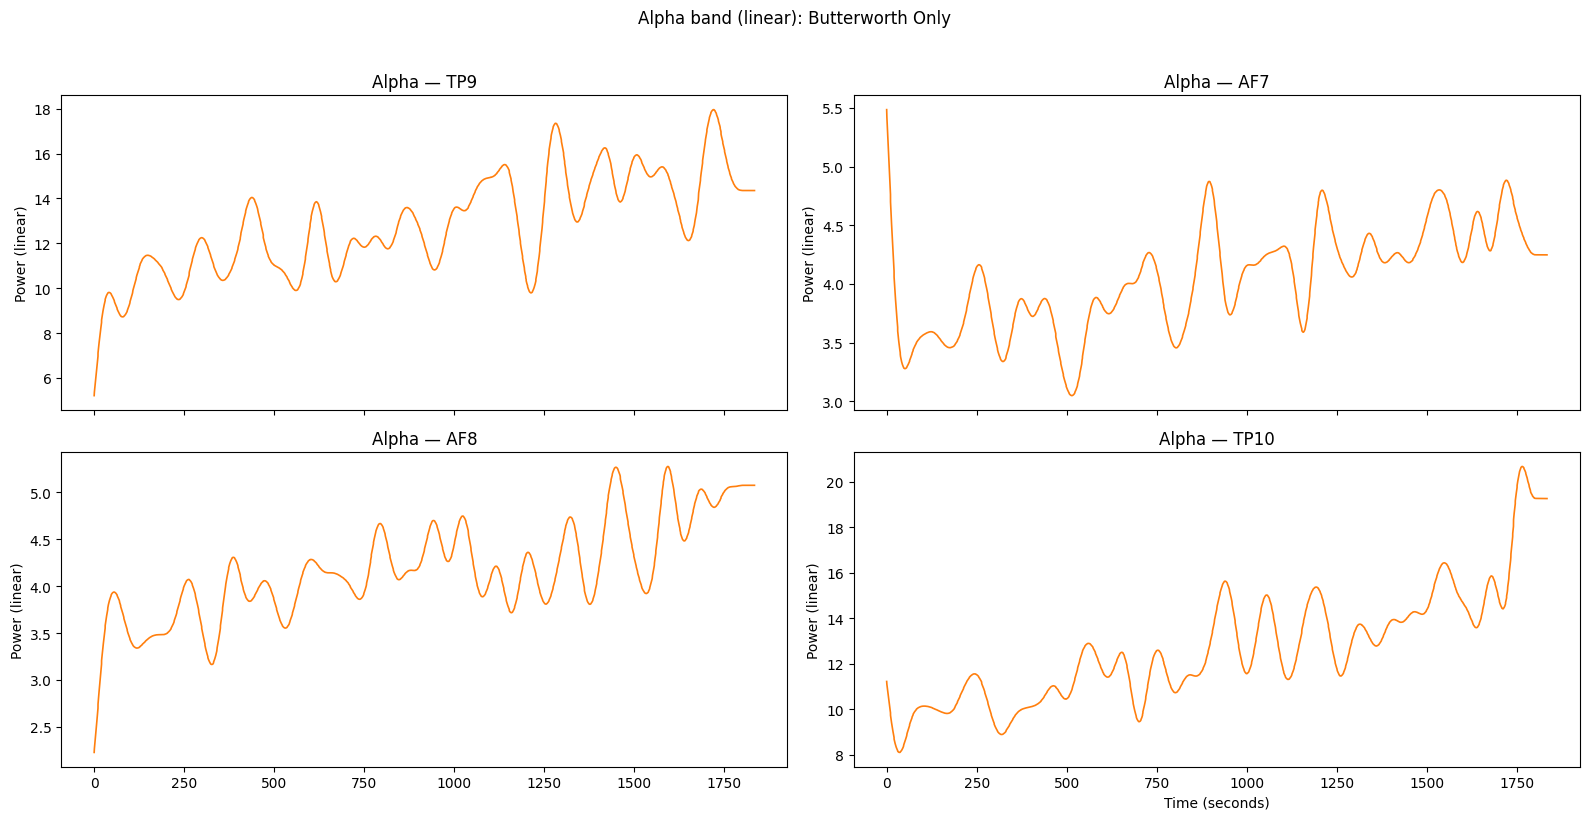

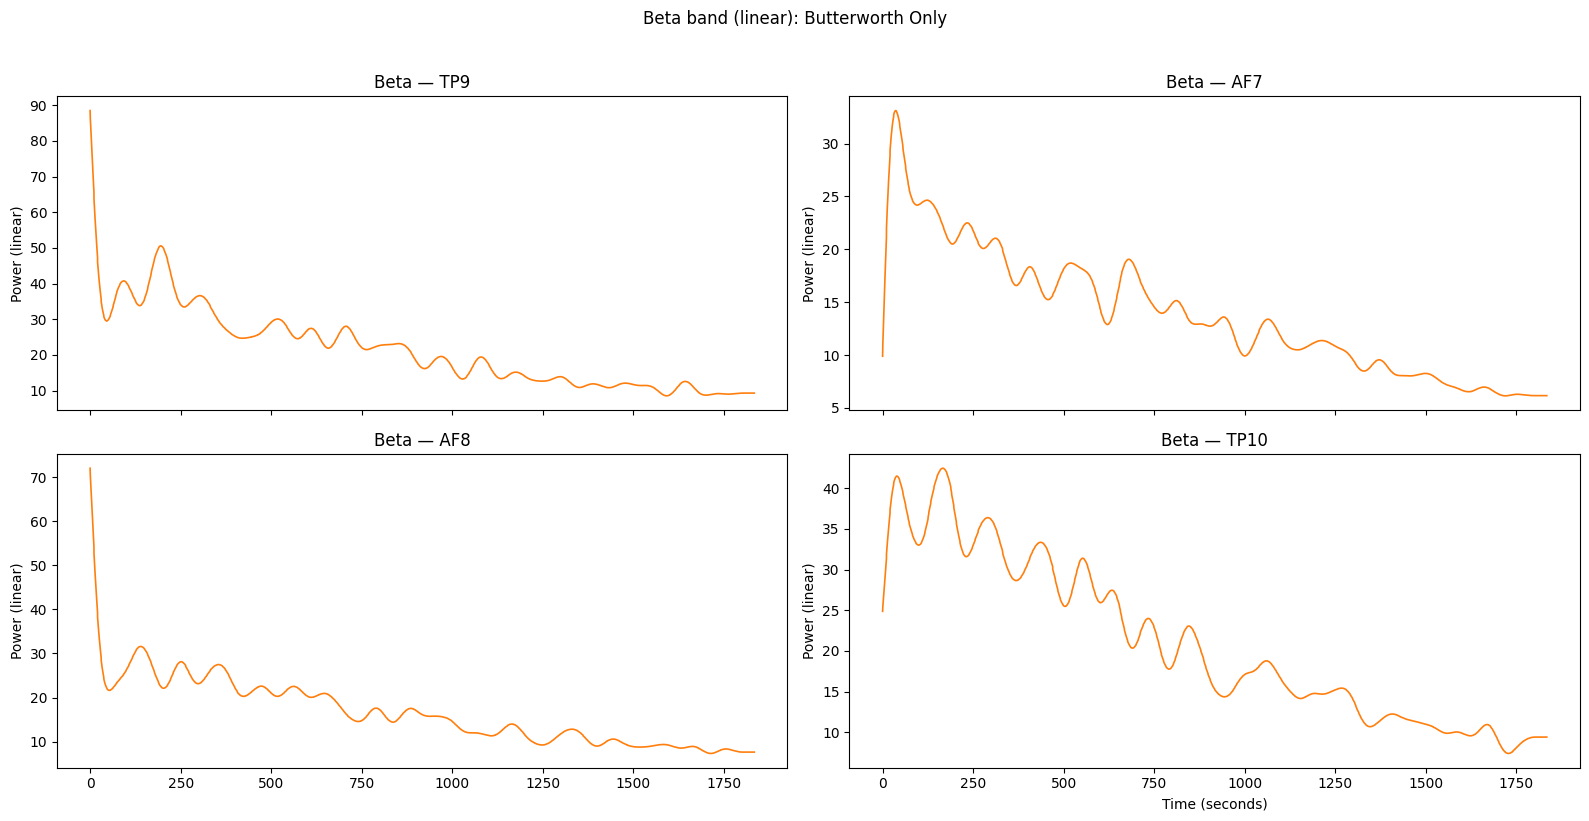

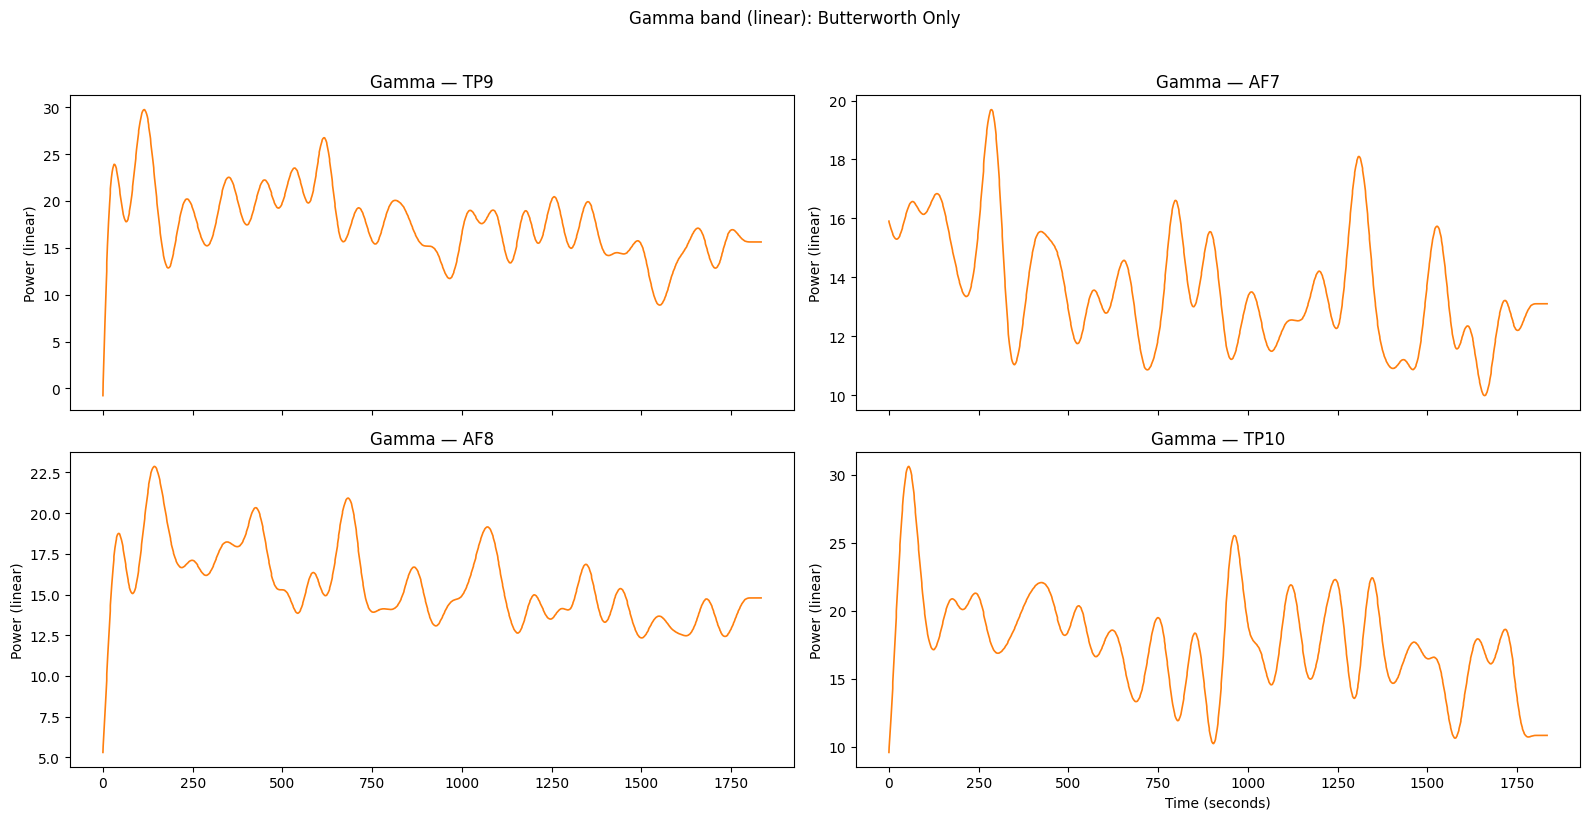

In [9]:
# --- Diagnostic plots: raw vs butterworth, per band (4 electrodes per figure) ---

time_seconds = df["TimeStamp_seconds"].to_numpy()

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
electrodes = ["TP9", "AF7", "AF8", "TP10"]

for band in bands:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
    axes = axes.ravel()

    for i, electrode in enumerate(electrodes):
        col_raw = f"{band}_{electrode}_lin"
        col_filt = f"{band}_{electrode}_lin_filt"

        axes[i].plot(time_seconds, df[col_raw].to_numpy(), linewidth=0.6, alpha=0.5, label="raw")
        axes[i].plot(time_seconds, df[col_filt].to_numpy(), linewidth=1.2, label="butterworth")
        axes[i].set_title(f"{band} — {electrode}")
        axes[i].legend(loc="upper right")

    fig.suptitle(f"{band} band (linear): Raw vs Butterworth", y=1.02)
    plt.tight_layout()
    plt.show()

# --- Butterworth only: all 5 bands × 4 electrodes in one 4×4 grid per band ---
for band in bands:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
    axes = axes.ravel()

    for i, electrode in enumerate(electrodes):
        col_filt = f"{band}_{electrode}_lin_filt"

        axes[i].plot(time_seconds, df[col_filt].to_numpy(), linewidth=1.2, color="tab:orange")
        axes[i].set_title(f"{band} — {electrode}")
        axes[i].set_ylabel("Power (linear)")

    fig.suptitle(f"{band} band (linear): Butterworth Only", y=1.02)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

**Cell 9 - Obtain averages**

In this step, we compute the mean power for each EEG frequency band across all four Muse electrodes (TP9, AF7, AF8, TP10), using the **filtered linear band power values**.

Each electrode was first converted from log₁₀ scale to linear power and then processed with a Butterworth low-pass filter to remove high-frequency noise. We now average the filtered values across electrodes to obtain a single representative band power per frequency at each time point.

This produces a spatially smoothed estimate of Delta, Theta, Alpha, Beta, and Gamma power that is more stable and suitable for engagement and fatigue analysis.

In [10]:
# --- Compute average filtered linear band power across electrodes ---
electrodes = ['TP9', 'AF7', 'AF8', 'TP10']

df['Delta_avg'] = df[[f'Delta_{e}_lin_filt' for e in electrodes]].mean(axis=1)
df['Theta_avg'] = df[[f'Theta_{e}_lin_filt' for e in electrodes]].mean(axis=1)
df['Alpha_avg'] = df[[f'Alpha_{e}_lin_filt' for e in electrodes]].mean(axis=1)
df['Beta_avg']  = df[[f'Beta_{e}_lin_filt'  for e in electrodes]].mean(axis=1)
df['Gamma_avg'] = df[[f'Gamma_{e}_lin_filt' for e in electrodes]].mean(axis=1)

avg_band_cols = ['Delta_avg', 'Theta_avg', 'Alpha_avg', 'Beta_avg', 'Gamma_avg']

print("Average filtered linear band power statistics:")
print(df[avg_band_cols].describe())

Average filtered linear band power statistics:
         Delta_avg    Theta_avg    Alpha_avg     Beta_avg    Gamma_avg
count  2110.000000  2110.000000  2110.000000  2110.000000  2110.000000
mean      4.548912     6.944283     8.413632    18.202428    16.095826
std       0.525685     1.308890     1.196686     8.247754     2.015709
min       3.274905     3.767377     6.037133     7.513776     7.507449
25%       4.270989     5.865500     7.436660    10.700891    14.476385
50%       4.510424     6.877192     8.389085    15.649194    15.957517
75%       4.750790     7.845198     9.270411    23.887988    17.299771
max      10.172828    10.105962    11.394227    48.823656    21.495304


**Cell 10 - Graphing average bands**

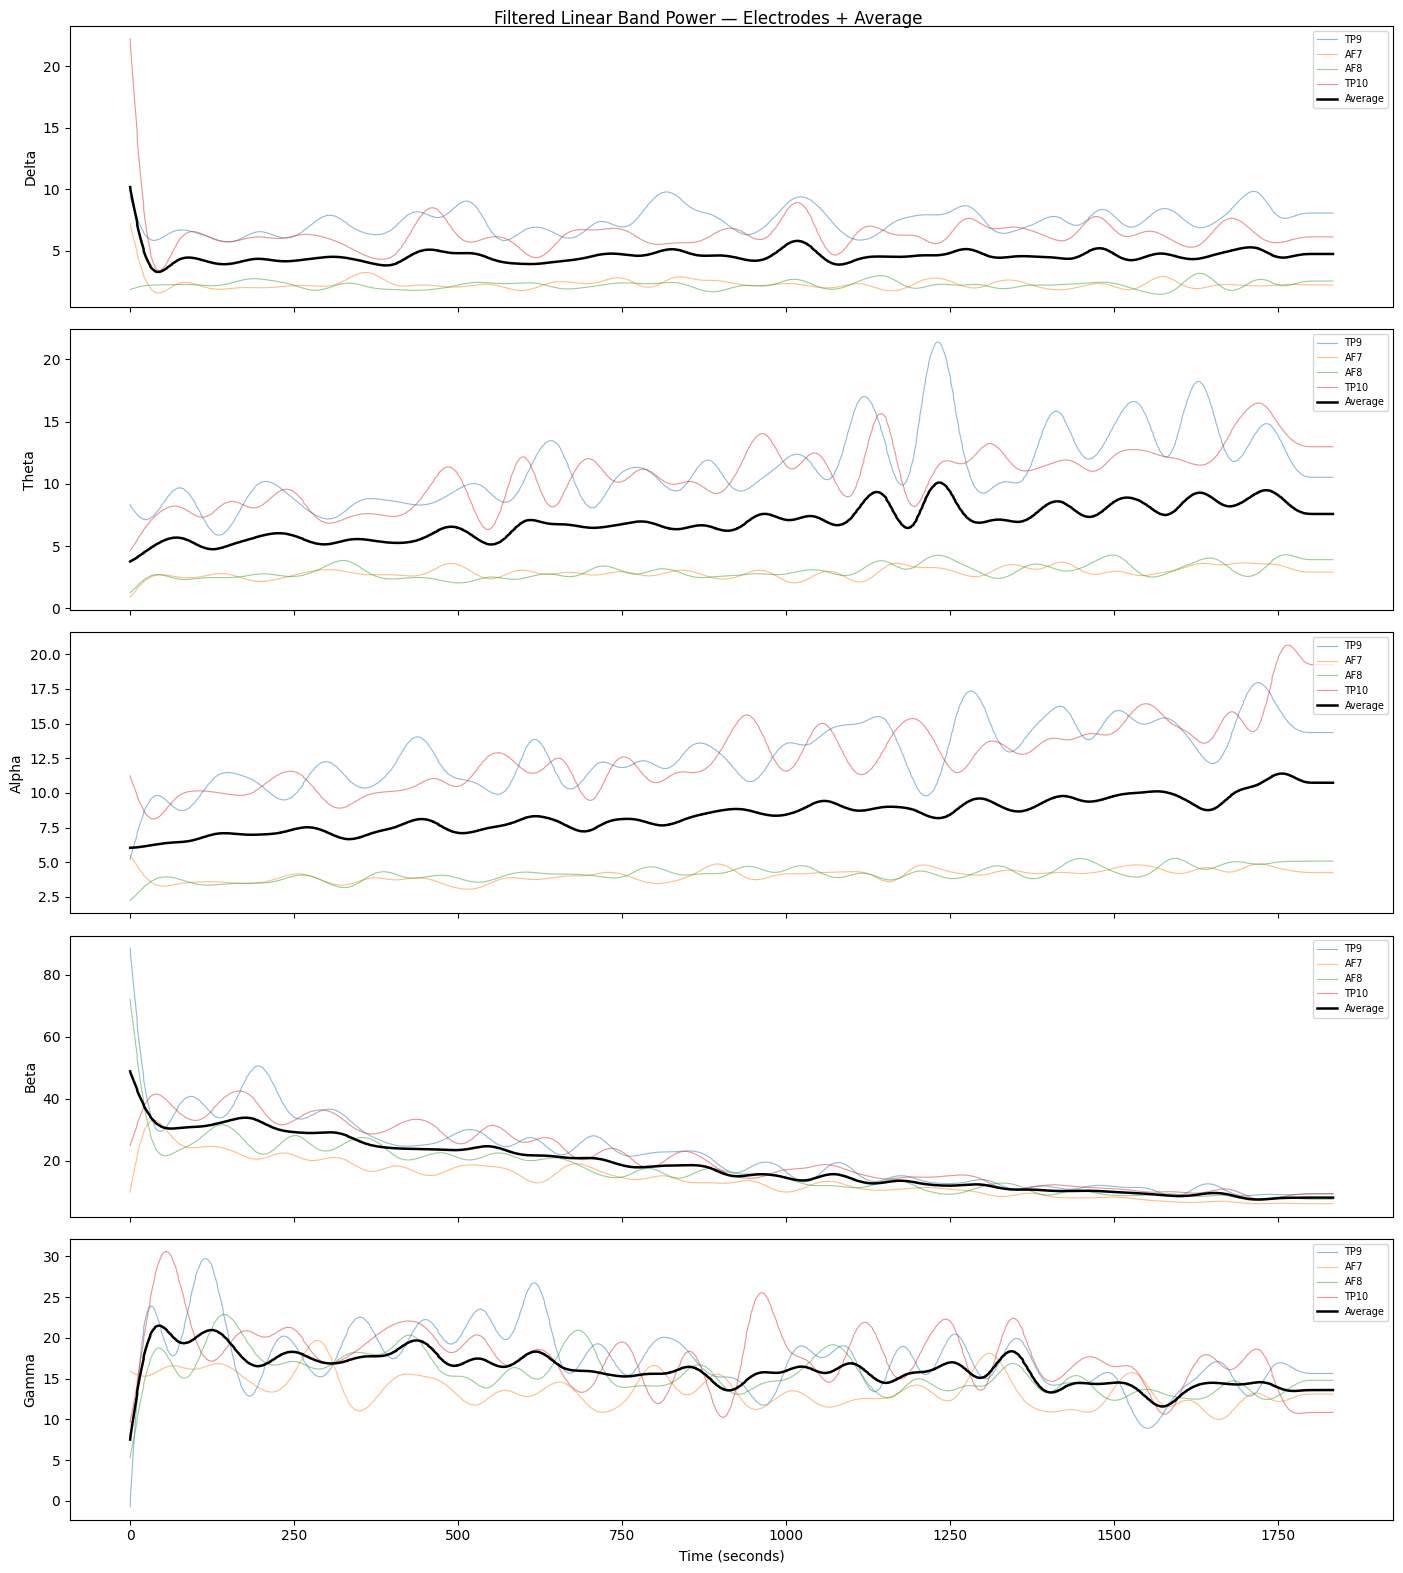

In [11]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
electrodes = ['TP9', 'AF7', 'AF8', 'TP10']

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

for i, band in enumerate(bands):
    for electrode in electrodes:
        axes[i].plot(df['TimeStamp_seconds'], df[f'{band}_{electrode}_lin_filt'],
                     linewidth=0.8, alpha=0.5, label=electrode)
    axes[i].plot(df['TimeStamp_seconds'], df[f'{band}_avg'],
                 linewidth=1.8, color='black', label='Average')
    axes[i].set_ylabel(band)
    axes[i].legend(loc='upper right', fontsize=7)

plt.xlabel('Time (seconds)')
fig.suptitle('Filtered Linear Band Power — Electrodes + Average')
plt.tight_layout()
plt.show()

**Cell 11 - Heatmap between average bands**

Some research has shown that some bands are correlated to other bands (such as gamma & beta or alpha & theta).

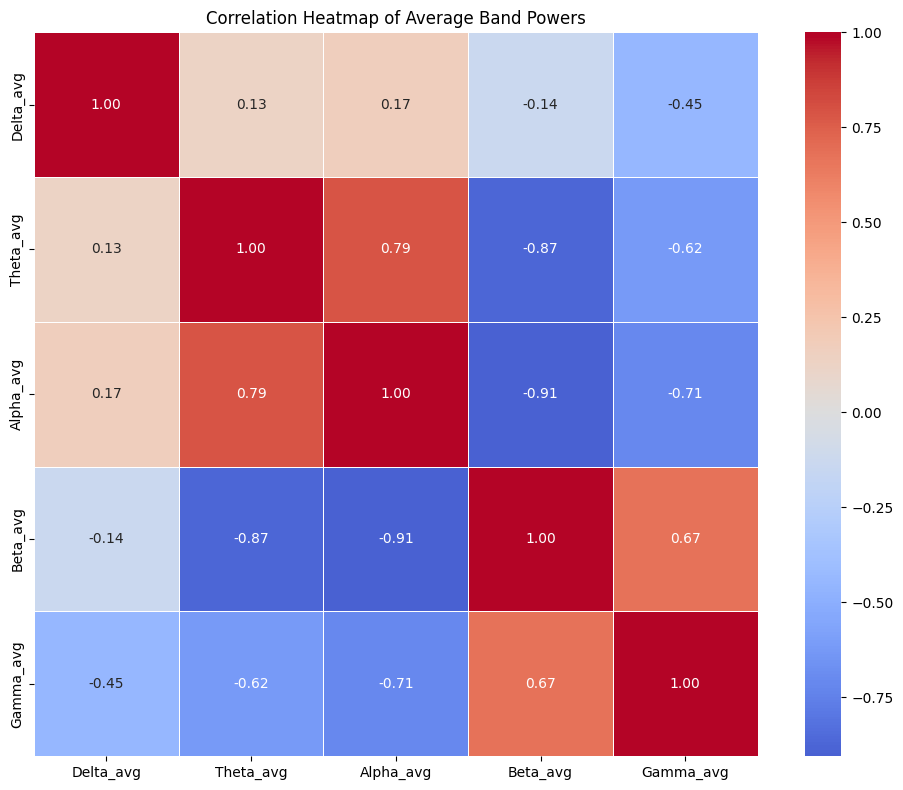

In [12]:
avg_band_cols = ['Delta_avg', 'Theta_avg', 'Alpha_avg', 'Beta_avg', 'Gamma_avg']
correlation_matrix = df[avg_band_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Average Band Powers')
plt.tight_layout()
plt.show()


**Cell 12 - Calculate and graph Engagement Index**

*Index:*
$$
EI(t) \;=\; \frac{\beta(t)}{\alpha(t) + \theta(t)}
$$

The **Engagement Index (EI)** quantifies cognitive focus by comparing task-related $\beta$ activity to $\alpha$ and $\theta$ activity, which are commonly associated with more relaxed or reduced attentional states. Higher EI values indicate greater relative engagement, while lower values may reflect decreased focus or emerging fatigue.

Median time step: 1.000000 s  →  Estimated Fs: 1 Hz


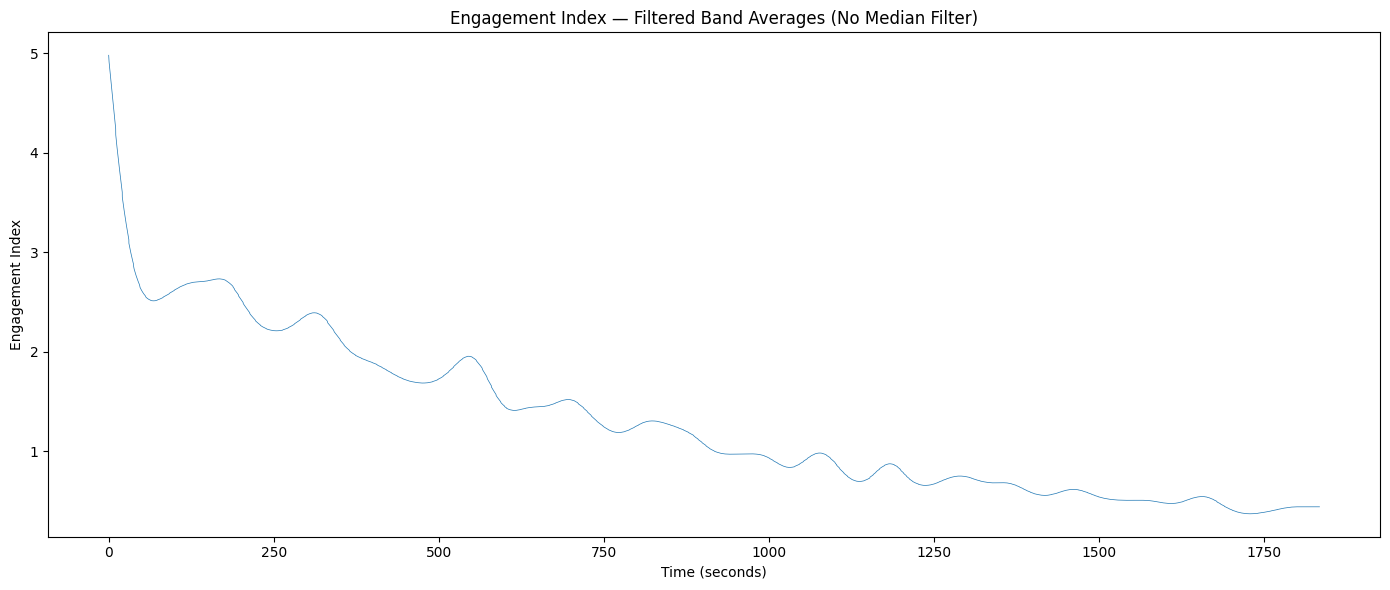

In [13]:
# --- Compute EI from filtered linear averages ---
denominator = df['Alpha_avg'] + df['Theta_avg']
denominator = denominator.where(denominator != 0, 1e-6)
df['EI_raw'] = df['Beta_avg'] / denominator

# Estimate sampling rate from TimeStamp
diffs = df['TimeStamp'].diff().dt.total_seconds().dropna()
median_dt = diffs.median()
estimated_fs = round(1.0 / median_dt) if median_dt > 0 else 1
print(f"Median time step: {median_dt:.6f} s  →  Estimated Fs: {estimated_fs} Hz")

# --- Plot EI ---
plt.figure(figsize=(14, 6))
plt.plot(df['TimeStamp_seconds'], df['EI_raw'], linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Engagement Index")
plt.title("Engagement Index — Filtered Band Averages (No Median Filter)")
plt.tight_layout()
plt.show()

**Cell 13 - Smooth and Export Engagement Index (EI)**

The sampling rate is estimated from timestamps to define a ~20-second centered rolling median window, producing a smoothed EI signal for trend analysis.

Blink events are extracted as a binary indicator, and a slim dataset containing time, raw EI, smoothed EI, blink, and heart rate is exported for downstream analysis.

In [14]:
# --- Adjustable smoothing window (in seconds) ---
ROLLING_WINDOW_SECONDS = 20   # ← change this value anytime

# --- Rolling median window (auto-calculated from seconds variable) ---
window_size = int(ROLLING_WINDOW_SECONDS * estimated_fs)
if window_size % 2 == 0:
    window_size += 1
print(f"Rolling median window: {window_size} samples (~{ROLLING_WINDOW_SECONDS} s)")

# --- Smooth EI ---
df['EI_median'] = df['EI_raw'].rolling(
    window=window_size,
    center=True,
    min_periods=1
).median()

# --- Smooth the existing band averages ---
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for band in bands:
    df[f"{band}_filt_avg_smoothed"] = df[f"{band}_avg"].rolling(
        window=window_size, center=True, min_periods=1
    ).median()

print("Smoothed band averages created:", [f"{b}_filt_avg_smoothed" for b in bands])

# --- Blink column (with safety check) ---
if 'Blink' in df.columns:
    print("Using existing 'Blink' column.")
elif 'Elements' in df.columns:
    df['Blink'] = df['Elements'].str.contains('blink', case=False, na=False).astype(int)
    print("Created 'Blink' column from 'Elements'.")
else:
    raise ValueError("Neither 'Blink' nor 'Elements' column found in DataFrame.")

# --- Build export columns ---
export_cols  = ['TimeStamp_seconds', 'EI_raw', 'EI_median', 'Blink']
export_names = ['Time_seconds',      'EI_raw', 'EI_median', 'Blink']

for band in bands:
    export_cols.append(f"{band}_filt_avg_smoothed")
    export_names.append(f"{band}_filt_avg_smoothed")

if 'Heart_Rate' in df.columns:
    export_cols.append('Heart_Rate')
    export_names.append('Heart_Rate')
else:
    print("Warning: 'Heart_Rate' column not found — skipping from export.")

# --- Export slim CSV ---
df_out = df[export_cols].copy()
df_out.columns = export_names

OUTPUT_CSV = "/Users/ericmiao/Desktop/EEGProject2.19/EI_Median.csv"
df_out.to_csv(OUTPUT_CSV, index=False)

print(f"\nSaved to: {OUTPUT_CSV} ({df_out.shape[0]} rows × {df_out.shape[1]} cols)")
print(f"Columns: {list(df_out.columns)}")

Rolling median window: 21 samples (~20 s)
Smoothed band averages created: ['Delta_filt_avg_smoothed', 'Theta_filt_avg_smoothed', 'Alpha_filt_avg_smoothed', 'Beta_filt_avg_smoothed', 'Gamma_filt_avg_smoothed']
Created 'Blink' column from 'Elements'.

Saved to: /Users/ericmiao/Desktop/EEGProject2.19/EI_Median.csv (2110 rows × 10 cols)
Columns: ['Time_seconds', 'EI_raw', 'EI_median', 'Blink', 'Delta_filt_avg_smoothed', 'Theta_filt_avg_smoothed', 'Alpha_filt_avg_smoothed', 'Beta_filt_avg_smoothed', 'Gamma_filt_avg_smoothed', 'Heart_Rate']


**Cell 14 - Plot the cleaned data**

Here is a visual representation of the cleaned EI data.

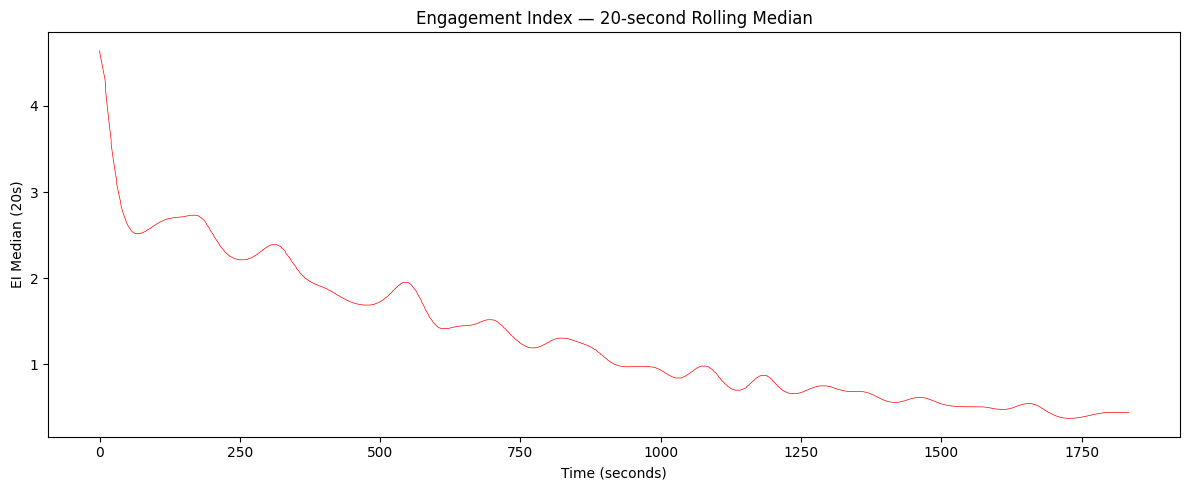

In [15]:
# Load the saved slim CSV
df_cleaned = pd.read_csv("/Users/ericmiao/Desktop/EEGProject2.19/EI_Median.csv")

plt.figure(figsize=(12, 5))
plt.plot(df_cleaned['Time_seconds'], df_cleaned['EI_median'], linewidth=0.5, color='red')
plt.ylabel('EI Median (20s)')
plt.title('Engagement Index — 20-second Rolling Median')
plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

## Phase 2: Phase 2: Statistical Baseline Calibration and Cognitive Fatigue Detection

In Phase 2, the processed engagement signal is statistically calibrated against a defined baseline period to detect cognitive fatigue over time.

This includes:
- Defining a user-adjustable baseline time window
- Computing baseline mean and standard deviation of EI
- Deriving a fatigue threshold (Baseline Mean − 2 × SD)
- Applying the threshold across the full time series
- Estimating blink density using a rolling window
- Normalizing blink intensity for visualization
- Overlaying baseline range, fatigue threshold, and blink density on the engagement signal

The outcome of Phase 2 is a statistically grounded fatigue detection model that identifies significant engagement drops relative to baseline and integrates behavioral markers for contextual interpretation.

**Cell 13 - Define baseline window + blink smoothing settings (easy to adjust).**

We compute the mean and standard deviation of the EI values within the defined baseline window to establish a statistical reference point. The baseline begins at 2 minutes (to allow time for entering a focused working state) and ends at 10 minutes.

In [16]:

# ============================================================
# USER-ADJUSTABLE
BASELINE_START_MINUTES = 2     # baseline start (minutes) ← e.g., set to 2 to skip first 2 min
BASELINE_END_MINUTES   = 10    # baseline end   (minutes)
BLINK_WINDOW_SECONDS   = 2     # smoothing window for blink density (seconds)
# ============================================================

baseline_start_seconds = BASELINE_START_MINUTES * 60
baseline_end_seconds   = BASELINE_END_MINUTES * 60

**Cell 14 - Load your Phase 1 output CSV (EI + Blink + Time)**

In [17]:
df_ei = pd.read_csv("/Users/ericmiao/Desktop/EEGProject2.19/EI_Median.csv")
df_ei.head()

,Time_seconds,EI_raw,EI_median,Blink,Delta_filt_avg_smoothed,Theta_filt_avg_smoothed,Alpha_filt_avg_smoothed,Beta_filt_avg_smoothed,Gamma_filt_avg_smoothed,Heart_Rate
0,0.0,4.979714,4.639174,0,8.838811,3.901119,6.047565,46.153675,10.083311,64.895434
1,0.6,4.911557,4.605425,0,8.709200,3.915566,6.049064,45.890822,10.334535,64.895434
2,1.6,4.843314,4.571677,0,8.579589,3.930013,6.050563,45.627969,10.585759,63.904971
3,2.6,4.775097,4.538151,0,8.451723,3.944771,6.052204,45.367229,10.833996,59.040242
4,3.6,4.707014,4.504624,0,8.323858,3.959528,6.053846,45.106489,11.082233,71.037100


**Cell 15 - Fatigue Detection Thresholds**

Within the baseline window, we compute the mean and standard deviation of the Engagement Index (EI) to establish a personalized statistical reference.

The mean represents the participant’s typical engagement level, while the standard deviation reflects normal fluctuation. We define fatigue as a statistically significant drop below baseline using:

Fatigue Threshold = Baseline Mean − (1.5 × SD)

A drop of 1.5 standard deviations corresponds to roughly the lowest 10% of values under normal variation, meaning sustained values below this threshold are unlikely to be random noise and instead indicate meaningful cognitive decline.

This threshold is then applied across the full session to detect and visualize fatigue events.

In [18]:
baseline_df = df_ei[
    (df_ei["Time_seconds"] >= baseline_start_seconds) &
    (df_ei["Time_seconds"] <= baseline_end_seconds)
]

baseline_mean = baseline_df["EI_median"].mean()
baseline_std  = baseline_df["EI_median"].std()

fatigue_threshold = baseline_mean - 1.5 * baseline_std
df_ei["Fatigue_Threshold"] = fatigue_threshold


**Cell 16 - Blink Density Estimation and Normalization**

This section computes blink intensity over time to provide a behavioral reference alongside the EEG signal.

First, it verifies that a Blink column (0 = no blink, 1 = blink) exists in the dataset. The sampling interval is then estimated to convert the blink smoothing window from seconds into the correct number of samples.

A rolling sum is applied to calculate blink density within the defined time window, transforming discrete blink events into a continuous intensity signal. Finally, the values are normalized between 0 and 1 to allow clear visualization and comparison with the Engagement Index.

In [19]:
if "Blink" not in df_ei.columns:
    raise ValueError("Your CSV must contain a 'Blink' column (0/1).")

dt = df_ei["Time_seconds"].diff().median()
if pd.isna(dt) or dt <= 0:
    blink_window_size = 1
else:
    blink_window_size = max(1, int(round(BLINK_WINDOW_SECONDS / dt)))

blink_intensity = df_ei["Blink"].rolling(
    window=blink_window_size,
    center=True,
    min_periods=1
).sum()

max_blink = blink_intensity.max()
blink_norm = blink_intensity / max_blink if max_blink and max_blink > 0 else blink_intensity * 0

**Cell 17 — Plot main graph and summary outputs**

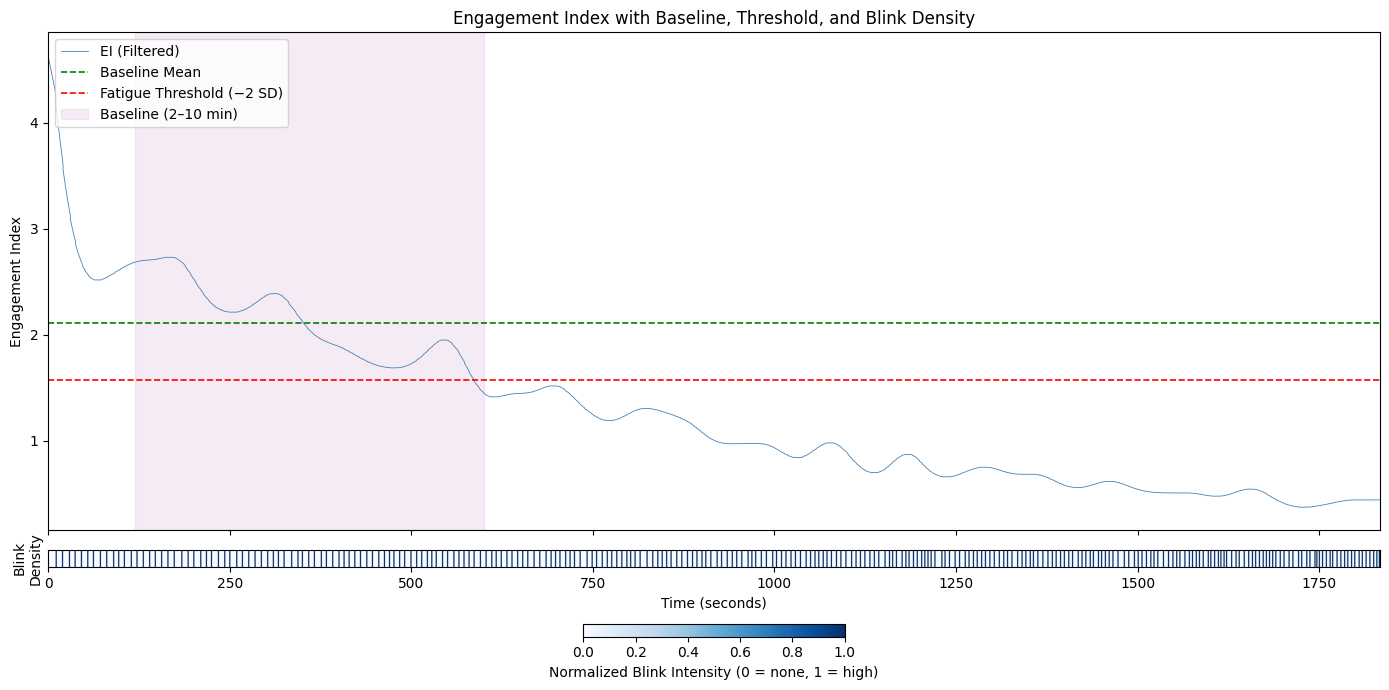

Baseline range    : 2–10 minutes (120–600 s)
Baseline mean     : 2.107656
Baseline std      : 0.357084
Fatigue threshold : 1.572030


In [20]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 7),
    sharex=True,
    gridspec_kw={'height_ratios': [4, 0.7]}
)

# ---- Top: EI ----
ax1.plot(
    df_ei["Time_seconds"],
    df_ei["EI_median"],
    linewidth=0.6,
    color="steelblue",
    label="EI (Filtered)"
)

ax1.axhline(y=baseline_mean,
            color="green",
            linestyle="--",
            linewidth=1.2,
            label="Baseline Mean")

ax1.axhline(y=fatigue_threshold,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label="Fatigue Threshold (−2 SD)")

ax1.axvspan(baseline_start_seconds, baseline_end_seconds,
            alpha=0.08, color="purple",
            label=f"Baseline ({BASELINE_START_MINUTES}–{BASELINE_END_MINUTES} min)")

ax1.set_ylabel("Engagement Index")
ax1.set_title("Engagement Index with Baseline, Threshold, and Blink Density")
ax1.legend(loc="upper left")

# ---- Bottom: Blink intensity strip ----
blink_strip = np.expand_dims(blink_norm.values, axis=0)

im = ax2.imshow(
    blink_strip,
    aspect="auto",
    cmap="Blues",
    extent=[
        df_ei["Time_seconds"].min(),
        df_ei["Time_seconds"].max(),
        0,
        1
    ]
)

ax2.set_yticks([])
ax2.set_ylabel("Blink\nDensity")
ax2.set_xlabel("Time (seconds)")

cbar = fig.colorbar(
    im,
    ax=ax2,
    orientation="horizontal",
    pad=0.65
)
cbar.set_label("Normalized Blink Intensity (0 = none, 1 = high)")

plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.show()

print(f"Baseline range    : {BASELINE_START_MINUTES}–{BASELINE_END_MINUTES} minutes "
      f"({baseline_start_seconds}–{baseline_end_seconds} s)")
print(f"Baseline mean     : {baseline_mean:.6f}")
print(f"Baseline std      : {baseline_std:.6f}")
print(f"Fatigue threshold : {fatigue_threshold:.6f}")
